In [2]:
import cv2
import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import pandas as pd
import pytorch_lightning as pl
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Load the data

In [2]:
test_path = '/Users/yujiejiang/Desktop/ML/chest_xray/test'
train_path = '/Users/yujiejiang/Desktop/ML/chest_xray/train'
val_path = '/Users/yujiejiang/Desktop/ML/chest_xray/val'

In [3]:
img_info = pd.read_csv('./img_info.csv')
test_df = img_info.loc[img_info.loc[:, 'data'] == 'Test']
train_df = img_info.loc[img_info.loc[:, 'data'] == 'Train']
val_df = test_df = img_info.loc[img_info.loc[:, 'data'] == 'Validation']

FileNotFoundError: [Errno 2] No such file or directory: './img_info.csv'

In [22]:
normal_images = train_df.loc[train_df.loc[:,'label'] == 0]
normal_images.loc[:,'imbalance'] = 1
train_df = pd.concat([train_df, normal_images, normal_images]).reset_index(drop=True)
print('Percentage of Normal Images in the Training Data: {}'.format(
    len(train_df.loc[train_df.loc[:,'label'] == 0])/len(train_df.loc[:,'label'])))
print('Percentage of Pneumonia Images in the Training Data: {}'.format(
    len(train_df.loc[train_df.loc[:,'label'] == 1])/len(train_df.loc[:,'label'])))

Percentage of Normal Images in the Training Data: 0.5093694606229425
Percentage of Pneumonia Images in the Training Data: 0.4906305393770575


/tmp/user/23071/ipykernel_2900154/907957275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_images.loc[:,'imbalance'] = 1


In [23]:
transforms = T.Compose(
    [
        T.Resize((224,224), antialias=None, interpolation=InterpolationMode.BICUBIC),
        T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),
        T.RandomEqualize(),
        T.ToTensor()
    ]
)

imbalance_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomErasing(p=0.2)
])

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir_path, transforms=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        csv_file (str): file path to the csv file you created /
        df (pandas df): pandas dataframe

        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
          transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = df
        self.img_dir = img_dir_path
        self.transforms = transforms
        
    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        img_path =  self.img_dir + self.img_labels.iloc[idx, 1]
        
        image = Image.open(img_path).convert('RGB')

        label = self.img_labels.iloc[idx, -1]
        
        imbalance = self.img_labels.iloc[idx, -2]

        if self.transforms:
            
            if imbalance and not label:
                image = transforms(image)
                image = imbalance_transform(image)
                
            else:
                image = transforms(image)
               
        return image, label

In [25]:
training_data = CustomImageDataset(train_df, train_path, transforms=transforms)
val_data = CustomImageDataset(val_df, val_path, transforms=transforms)
test_data = CustomImageDataset(test_df, test_path, transforms=transforms)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [27]:
training_data[0]

FileNotFoundError: [Errno 2] No such file or directory: 'NORMAL2-IM-0927-0001.jpeg'

## Model Setup

In [9]:
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torchvision.transforms import ToTensor
from PIL import Image

In [4]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        
        self.LeNet = nn.Sequential(     
            # convolutional layers            
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=0),    # CONVOLUTION 
              nn.BatchNorm2d(6),
              nn.ReLU(),
              nn.Dropout(p=dropout_rate),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),   # CONVOLUTION 
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(p=dropout_rate),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            # fully connected layers
            nn.Flatten(),
            # output layer
            nn.Linear(16 * 54 * 54, 2)                                # OUTPUT LAYER
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [5]:
model_1 = CustomNeuralNetwork()

In [13]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [14]:
EPOCHS = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    # TRAIN
    # Make sure gradient tracking is on, and do a pass over the data
    model_1.train()
    running_loss = 0.0
    running_matched = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data           # NOTE: depending on how you implemented your dataset class's __getitem__ it could be labels, inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of the loss
        running_loss += loss.item()

        # CALCULATE ACCURACY METRIC
        _, preds = torch.max(outputs, 1)  # Find out the predicted class with the highest prob
        running_matched += torch.sum(preds == labels.data) # caculate the number of matched labels

    avg_train_loss = running_loss / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
    avg_train_acc = running_matched.double() / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # VALIDATE
    # In the validation part, we don't want to keep track of the gradients 
    model_1.eval()
    running_val_loss = 0.0
    running_val_matched = 0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            outputs = model_1(inputs)
            loss = criterion(outputs, labels)

            # keep track of the loss
            running_val_loss += loss.item()

            # CALCULATE ACCURACY METRIC
            _, preds = torch.max(outputs, 1)
            running_val_matched += torch.sum(preds == labels.data)

    avg_val_loss = running_val_loss / (i + 1)
    avg_val_acc = running_val_matched.double() / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")


NameError: name 'train_dataloader' is not defined

In [ ]:
#TEST
model_1.eval()
running_test_loss = 0.0
running_test_matched = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)

        # keep track of the loss
        running_test_loss += loss.item()

        # CALCULATE ACCURACY METRIC
        _, preds = torch.max(outputs, 1)
        running_test_matched += torch.sum(preds == labels.data)

avg_test_loss = running_test_loss
avg_test_acc = running_test_matched.double() / len(test_dataloader.dataset)

# Print epoch summary
print("Test Loss: {}".format(avg_test_loss))
print("Test Acc: {}".format(avg_test_acc))

# Trial on SoftMax

In [3]:
# softmax record of updated accuracies & losses
model = torch.load('./softmaxmodel.PT')

In [4]:
# softmax
softmax_output = {'train_acc_output' : [0.9663, 0.9713, 0.9720, 0.9730, 0.9773, 0.9768, 0.9782, 0.9804, 0.9816, 0.9844, 0.9844, 0.9842, 0.9838, 0.9849, 0.9877, 0.9877, 0.9896, 0.9889, 0.9906,0.9886]
, 'train_loss_output': [0.10173026018685871, 0.09072341884095822,
 0.08354679867625237,
 0.07615594978955004,
 0.07161806333028982,
 0.07035121841416243,
 0.06614582539506016,
 0.06039045020307024,
 0.05711717502544484,
 0.052785396883865035,
 0.051331473702204325,
 0.05054859138063846,
 0.04812943094199704,
 0.044066273877697605,
 0.04058976383549311,
 0.040024005011805606,
 0.0375443015457882,
 0.038703201511394114,
 0.034343408585916606,
 0.037115964159790064],
'val_acc_output' : [0.8125, 0.5000, 0.5000, 0.6250, 0.7500, 0.7500, 0.6250, 0.8750, 0.8125, 0.5000, 0.5000, 0.9375, 0.8750, 0.9375, 1., 0.8125, 0.8125, 0.8750, 0.9375, 0.9375]
,'val_loss_output' : [0.5162,
 0.6804,
 0.5998,
 0.5667,
 0.4982,
 0.4728,
 0.5531,
 0.4017,
 0.4853,
 0.6948,
 0.7799,
 0.3926,
 0.3511,
 0.3279,
 0.3167,
 0.3746,
 0.4695,
 0.3311,
 0.3432,
 0.3215]}

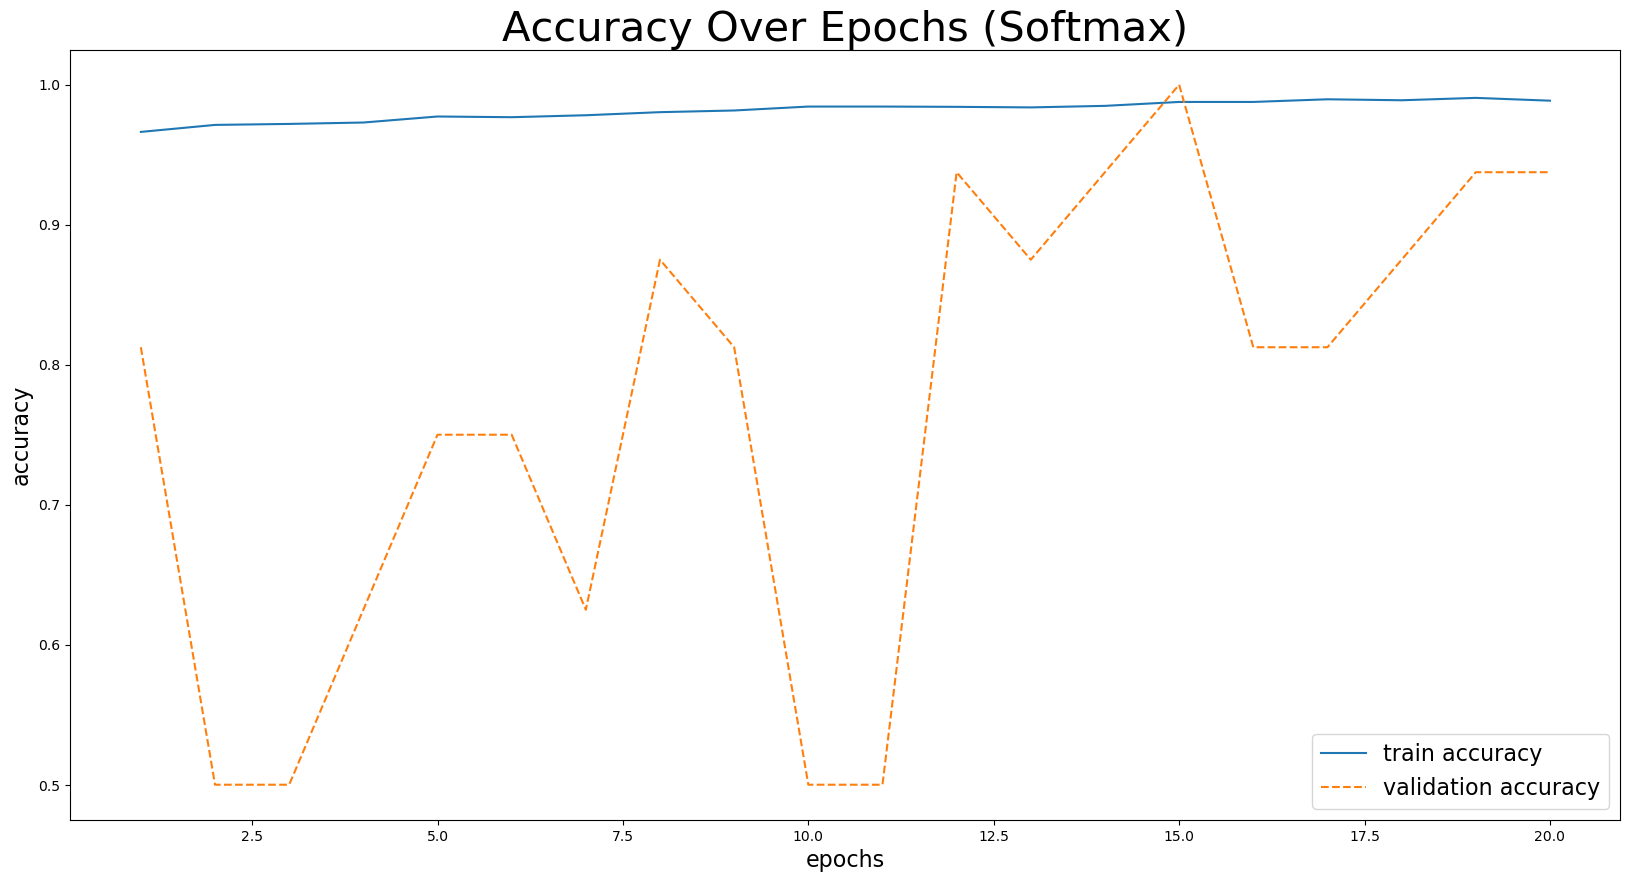

In [5]:
# Plot Accuracy Over Epochs (Softmax)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, softmax_output['train_acc_output'], label = 'train accuracy', linestyle = 'solid')
ax.plot(epochs_array, softmax_output['val_acc_output'], label = 'validation accuracy', linestyle = 'dashed')

ax.set_title('Accuracy Over Epochs (Softmax)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

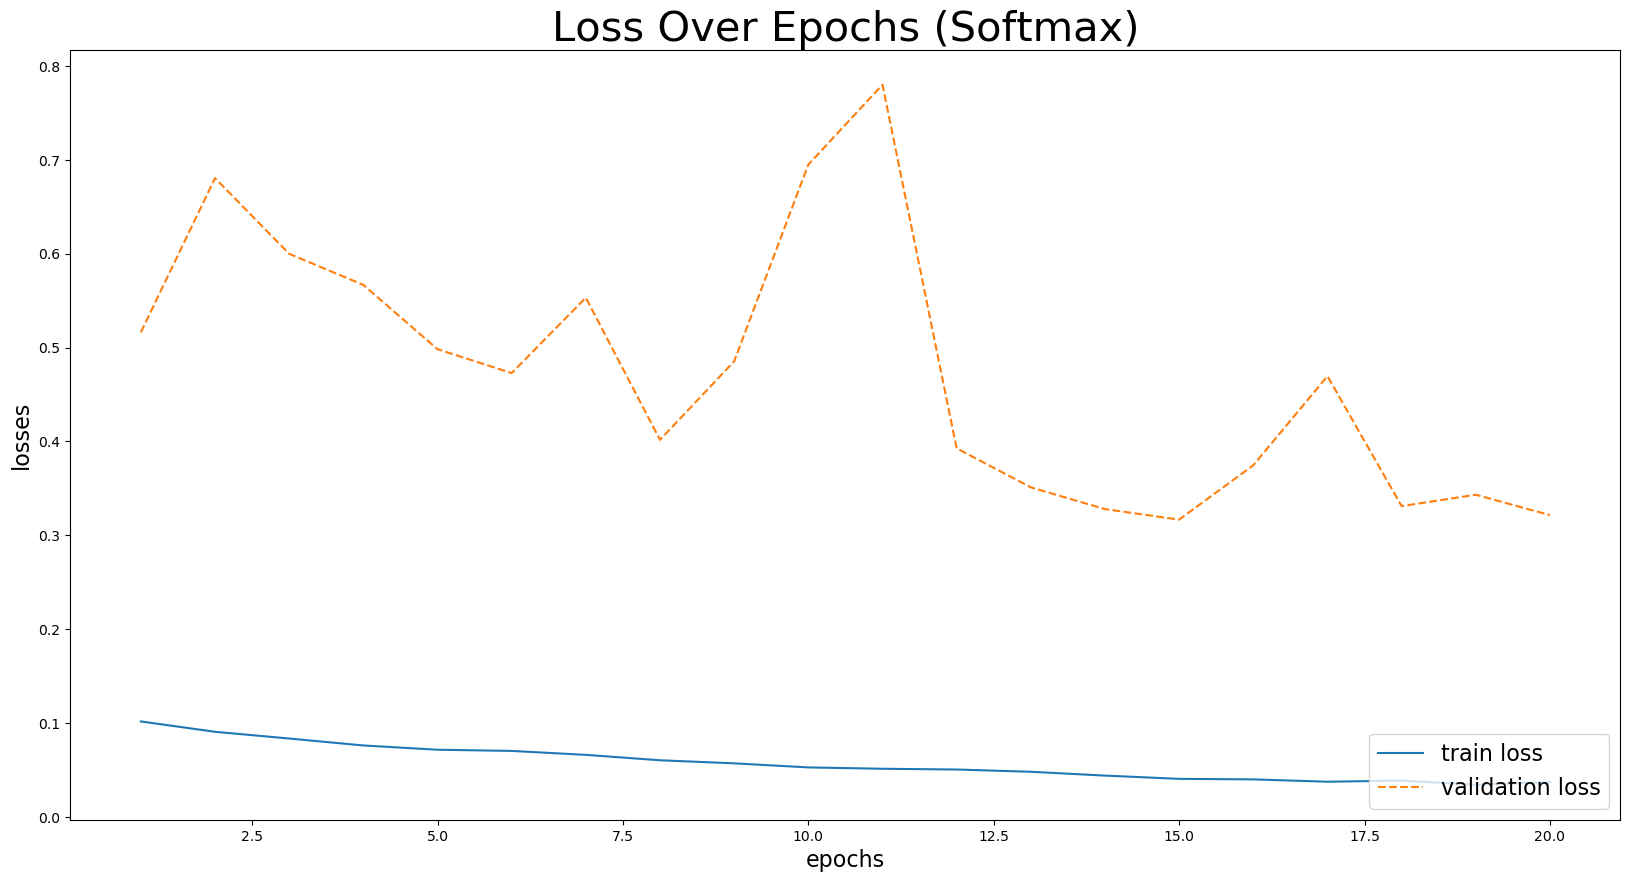

In [6]:
# Plot Loss Over Epochs (Softmax)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, softmax_output['train_loss_output'], label = 'train loss', linestyle = 'solid')
ax.plot(epochs_array, softmax_output['val_loss_output'], label = 'validation loss', linestyle = 'dashed')

ax.set_title('Loss Over Epochs (Softmax)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("losses", fontsize=16)
plt.show()

# Trial on ReLu

In [7]:
# Load Output
Relu_output = {"train_losses": [0.8600084423387964, 0.12976960314817035, 0.08371825903774269, 0.06391572049300696, 0.0559165018184426, 0.0447782653162346, 0.027934952362087526, 0.022565101686444496, 0.021624810340947608, 0.020703983764941505, 0.015272842294272719, 0.014044801473632575, 0.011801864481024113, 0.013236610422609374, 0.012739445865830226, 0.008216436558981396, 0.00727962186271813, 0.005667039101676745, 0.0075817683987078185, 0.008342319490052872], "train_accuracies": [0.8919979741706762, 0.9598632565206381, 0.973410990124082, 0.9784755634337807, 0.9802481640921752, 0.9840465940744493, 0.9906305393770575, 0.9922765257027095, 0.9927829830336794, 0.9925297543681945, 0.9956951126867561, 0.9951886553557863, 0.9975943276778931, 0.9954418840212712, 0.9960749556849835, 0.9975943276778931, 0.9984806280070904, 0.9992403140035452, 0.9984806280070904, 0.9972144846796658], "val_losses": [0.25953003764152527, 0.4955205023288727, 0.07319729030132294, 0.38255125284194946, 0.6669390201568604, 0.059240106493234634, 0.24048185348510742, 0.4658348560333252, 0.09841630607843399, 0.33186373114585876, 0.3751453757286072, 0.12435400485992432, 0.2910654544830322, 0.45721787214279175, 0.15137851238250732, 0.039100226014852524, 0.2244478017091751, 0.1994958519935608, 0.13904070854187012, 0.2117999792098999], "val_accuracies": [0.875, 0.75, 1.0, 0.9375, 0.75, 1.0, 0.875, 0.8125, 1.0, 0.8125, 0.8125, 0.9375, 0.8125, 0.8125, 0.9375, 1.0, 0.8125, 0.875, 0.9375, 0.9375]}
print(Relu_output['train_losses'])

[0.8600084423387964, 0.12976960314817035, 0.08371825903774269, 0.06391572049300696, 0.0559165018184426, 0.0447782653162346, 0.027934952362087526, 0.022565101686444496, 0.021624810340947608, 0.020703983764941505, 0.015272842294272719, 0.014044801473632575, 0.011801864481024113, 0.013236610422609374, 0.012739445865830226, 0.008216436558981396, 0.00727962186271813, 0.005667039101676745, 0.0075817683987078185, 0.008342319490052872]


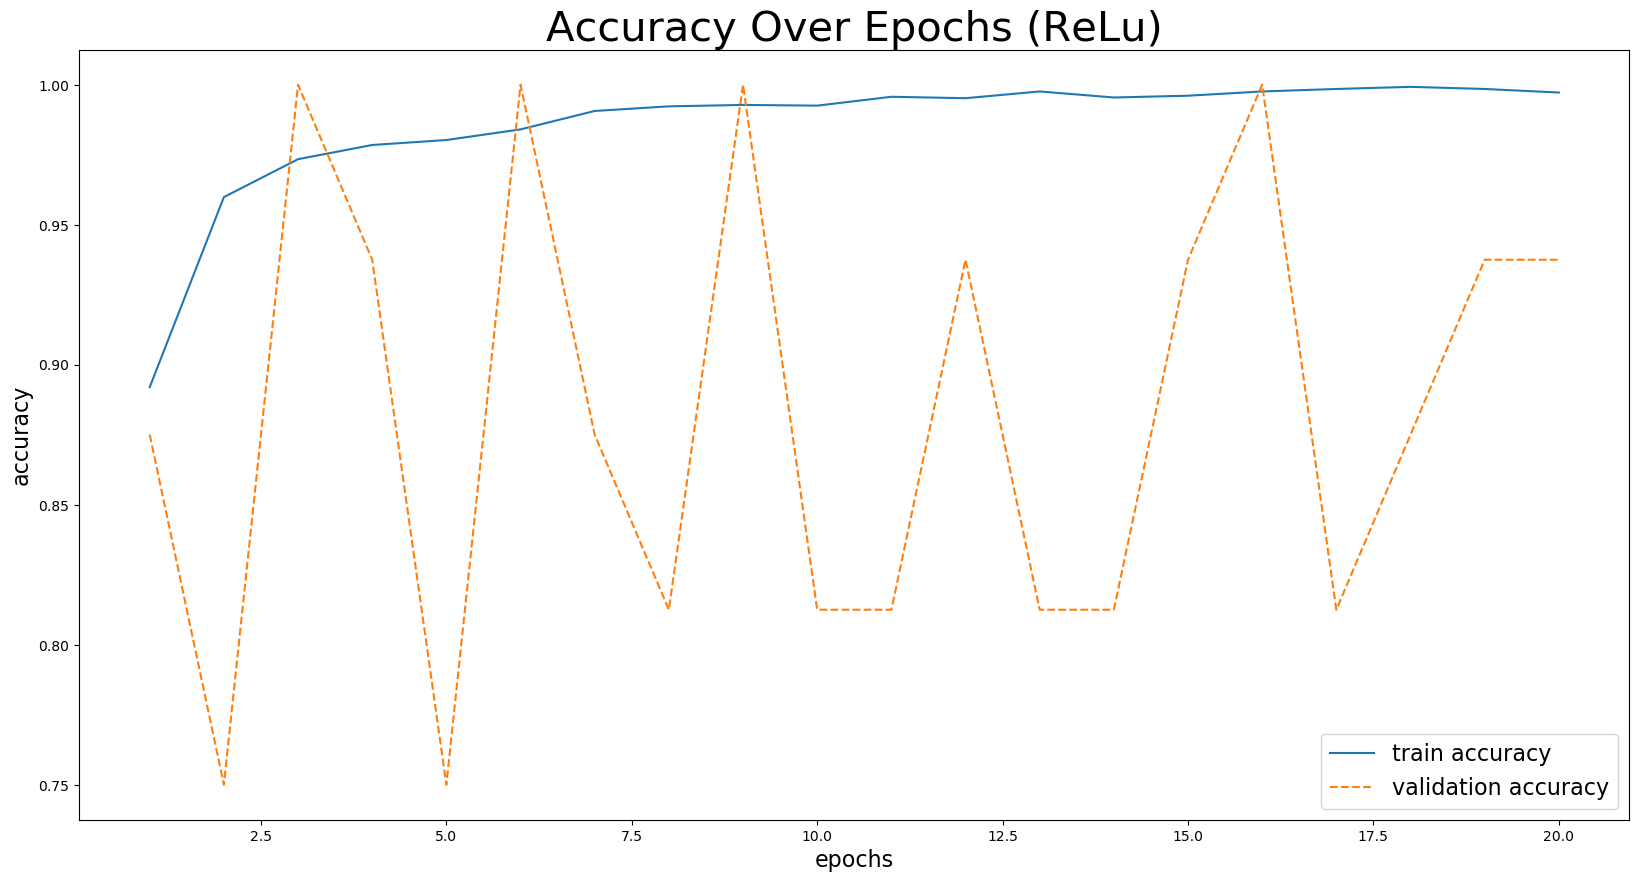

In [8]:
# Plot Accuracy Over Epochs (ReLu)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, Relu_output['train_accuracies'], label = 'train accuracy', linestyle = 'solid')
ax.plot(epochs_array, Relu_output['val_accuracies'], label = f'validation accuracy', linestyle = 'dashed')

ax.set_title('Accuracy Over Epochs (ReLu)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

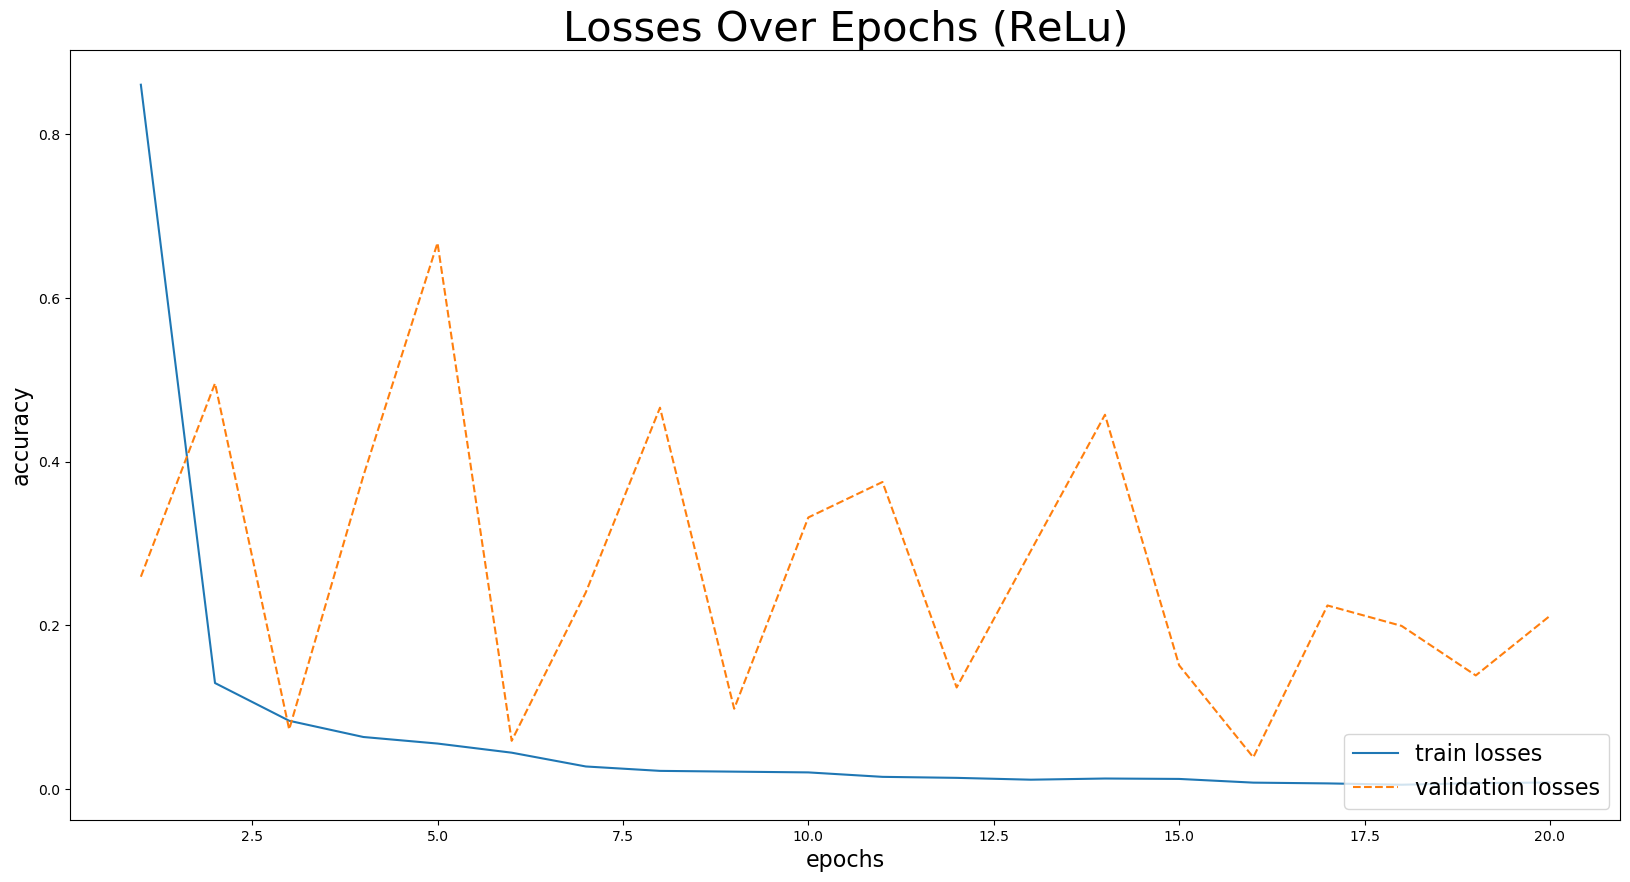

In [9]:
# Plot Losses Over Epochs (ReLu)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, Relu_output['train_losses'], label = 'train losses', linestyle = 'solid')
ax.plot(epochs_array, Relu_output['val_losses'], label = 'validation losses', linestyle = 'dashed')

ax.set_title('Losses Over Epochs (ReLu)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

# Trial on Sigmoid

In [10]:
# Load output
sigmoid_output = {'train_losses': [4.689377228744449,
  1.055143601899486,
  0.6916972143845933,
  0.4603541701322801,
  0.4209007532110498,
  0.4890190195941203,
  0.31507627059111276,
  0.2438279940125217,
  0.6442550289394867,
  0.392927763181609,
  0.43233570447116487,
  0.39626546221176884,
  0.23865778454496794,
  0.263433514934619,
  0.36094445983819184,
  0.2842149847908126,
  0.31976116906791446,
  0.3131407317067046,
  0.2007023928599665,
  0.23071422455869917],
 'train_accuracies': [0.7841225626740947,
  0.8990883768042542,
  0.9155482400607748,
  0.9353000759685997,
  0.934033932641175,
  0.9279564446695366,
  0.9474550519118764,
  0.95277285388706,
  0.9146619397315776,
  0.9411243352747531,
  0.9323879463155229,
  0.9390985059508736,
  0.9528994682198025,
  0.9450493795897695,
  0.9399848062800709,
  0.945429222587997,
  0.9422638642694353,
  0.9426437072676627,
  0.9572043555330464,
  0.9510002532286654],
 'val_losses': [0.3565775752067566,
  1.4871867895126343,
  1.7286958694458008,
  2.4434051513671875,
  2.7252652645111084,
  2.669721841812134,
  1.56052565574646,
  2.3020570278167725,
  1.107877492904663,
  0.22137123346328735,
  1.3852976560592651,
  1.3219811916351318,
  1.828873872756958,
  2.0985422134399414,
  2.3976519107818604,
  2.623682975769043,
  3.255777359008789,
  3.3309435844421387,
  0.49168169498443604,
  2.3181726932525635],
 'val_accuracies': [0.875,
  0.6875,
  0.6875,
  0.5625,
  0.5,
  0.5,
  0.5,
  0.5,
  0.625,
  0.875,
  0.625,
  0.5625,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.75,
  0.5]}


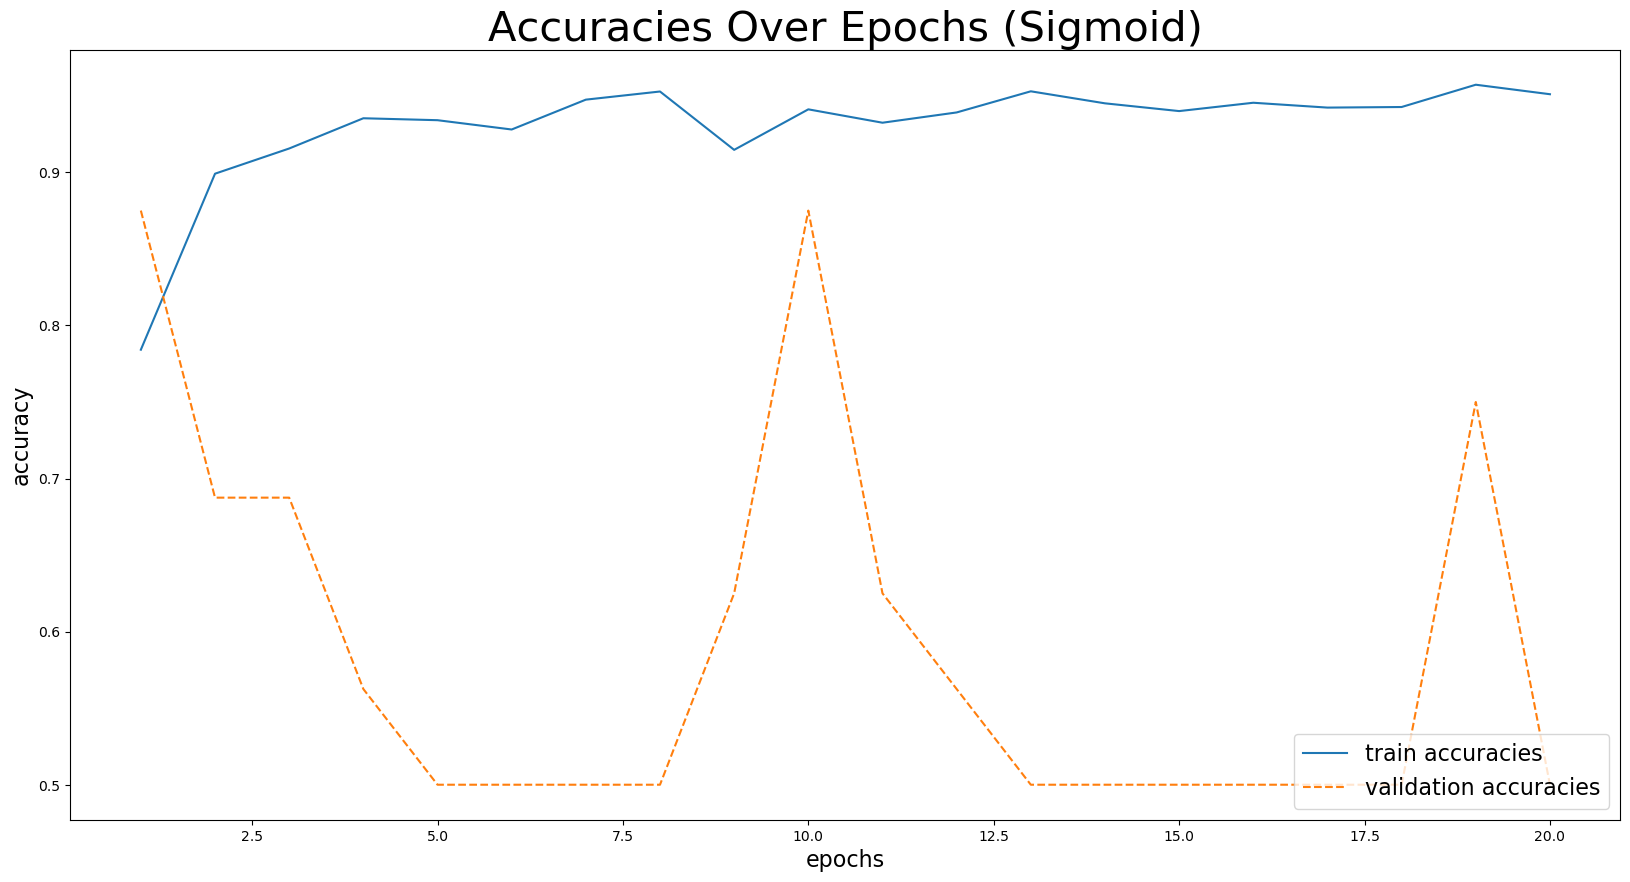

In [11]:
# Plot Accuracies Over Epochs (Sigmoid)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, sigmoid_output['train_accuracies'], label = 'train accuracies', linestyle = 'solid')
ax.plot(epochs_array, sigmoid_output['val_accuracies'], label = 'validation accuracies', linestyle = 'dashed')

ax.set_title('Accuracies Over Epochs (Sigmoid)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()

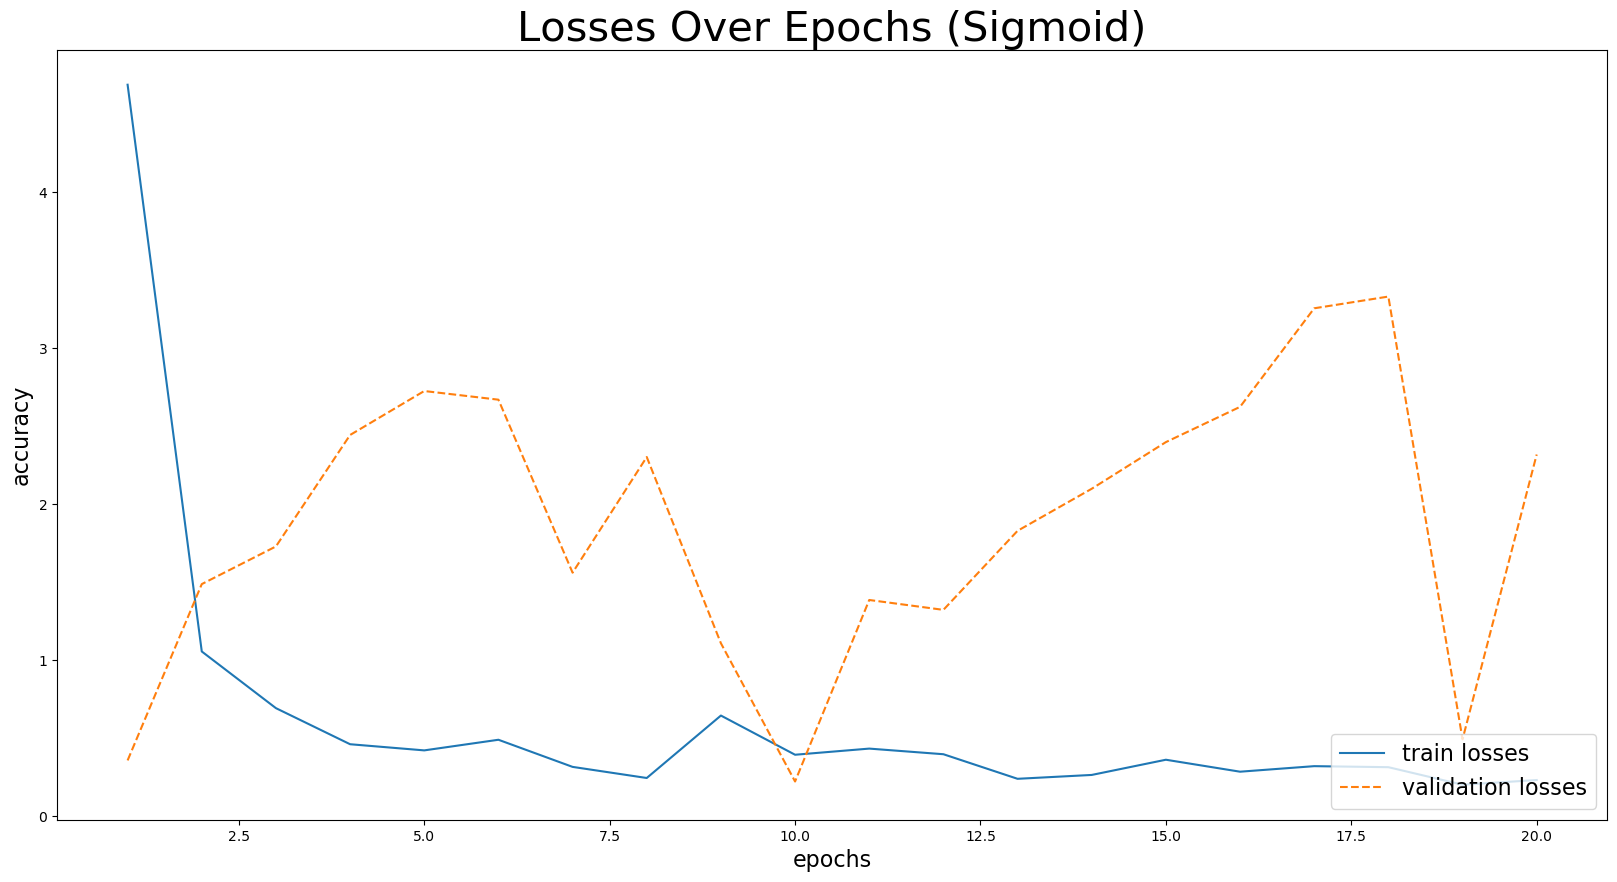

In [12]:
# Plot Losses Over Epochs (Sigmoid)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
epochs_array = [i for i in range(1, 21)]

ax.plot(epochs_array, sigmoid_output['train_losses'], label = 'train losses', linestyle = 'solid')
ax.plot(epochs_array, sigmoid_output['val_losses'], label = 'validation losses', linestyle = 'dashed')

ax.set_title('Losses Over Epochs (Sigmoid)', fontsize=30)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.show()